# helper functions

In [ ]:
%%time
%run theory_basics.ipynb
from IPython.display import clear_output
clear_output()

In [2]:
from scipy.ndimage import zoom
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [3]:
def calculate_frequencies(indices, dt, signal_length):
    """Calculate and interpolate frequencies"""
    time_periods = np.diff(indices) * dt
    frequencies = 1 / time_periods
    midpoints = indices[:-1] + np.diff(indices) / 2
    f = interp1d(midpoints, frequencies, kind='linear', fill_value='extrapolate', bounds_error=False)
    return f(np.arange(signal_length))

def infer_frequencies(x, dt=1/N):
    """
    Assign current frequency at each timestep.
    
    Parameters:
       x(numpy.ndarray): input, continuous signal
       dt(float): time difference between each subsequent sample (1/Fs)
       
    Returns:
       numpy.ndarray: current frequency at each timestep
    """
    # Detect peaks and troughs
    peak_indices = find_peaks(x)[0]
    trough_indices = find_peaks(-x)[0]

    # Calculate frequencies using peaks and troughs independently
    peak_freqs = calculate_frequencies(peak_indices, dt, len(x))
    trough_freqs = calculate_frequencies(trough_indices, dt, len(x))

    # Combine the frequencies calculated from peaks and troughs
    combined_freqs = (peak_freqs + trough_freqs) / 2

    return combined_freqs

In [4]:
def get_angle(f):
    return np.angle(np.fft.fft(f)[1])

def get_angles(F):
    return np.angle(np.fft.fft(F, axis=1)[:, 1])

def get_amps(F):
    return np.abs(np.fft.fft(F, axis=1)[:, 1])

In [5]:
def to_theta(x):
    return ((x + np.pi) % (2*np.pi)) - np.pi

In [6]:
def mean_angle(amps, angs):
    s = sum(amps)
    return np.angle(np.sum([
        amp * np.exp(1j*ang)
        for amp, ang in zip(amps, angs)
    ], axis=0))

In [7]:
def get_dx(X, w, i, f_I, phi, u, alpha, theta, t, delay_i, T, dt, train=True):
    I_in = f_I(w, X[i - delay_i])
    return (-X[i - 1] + phi(int(train) * u(t[i] + theta, T) + I_in)) * dt * alpha

def f_I_conv_circ_fft(signal, ker):
    return np.real(np.fft.ifft(np.fft.fft(signal) * np.fft.fft(ker)))

In [8]:
def plot_system_segment(start, end, X, W, t):
    plt.figure(figsize=(12, 5))
    gs = plt.GridSpec(1, 4, width_ratios=[1, 2, 2, 0.1])
    ax1 = plt.subplot(gs[0, 0])
    ax1.imshow(X[start:end], extent=[0, N/(end-start)*(t[end]-t[start]), t[end], t[start]])
    ax1.set_ylabel('time (s)')
    ax1.set_xlabel('x')
    ax1.set_title(r'$r(x, t)$')
    ax2 = plt.subplot(gs[0, 1])
    X_fft = np.fft.fft(X, axis=1)[:, 1]
    ax2.scatter(X_fft.real[start:end], X_fft.imag[start:end], c=t[start:end], s=1)
    ax2.set_xlabel('Re')
    ax2.set_ylabel('Im')
    ax2.set_title(r'$\mathcal{F}_{x}[r](\xi=\frac{1}{T}, t)$')
    ax3 = plt.subplot(gs[0, 2])
    W_fft = np.fft.fft(W, axis=1)[:, 1]
    w_fft_max_h = np.abs(W_fft.real[start:end]).max()+5
    w_fft_max_v = np.abs(W_fft.imag[start:end]).max()+5
    w_fft_max = max(w_fft_max_h, w_fft_max_v)
    scatter = ax3.scatter(W_fft.real[start:end], W_fft.imag[start:end], c=t[start:end], s=1)
    ax3.set_xlim(-w_fft_max, w_fft_max)
    ax3.set_ylim(-w_fft_max, w_fft_max)
    ax3.set_xlabel('Re')
    ax3.set_ylabel('Im')
    ax3.set_title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
    ax_colorbar = plt.subplot(gs[0, -1])
    cbar = plt.colorbar(scatter, cax=ax_colorbar)
    cbar.set_label('time (s)')
    plt.tight_layout()
    plt.show()

In [9]:
freqs = np.fft.fftfreq(N)

In [10]:
def get_x_from_u(u_):
    return np.fft.ifft(np.fft.fft(phi(u_)) / (tau_x/dt * 2 * np.pi * 1j * freqs + 1)).real
    
def get_w_from_x(x, delay_i):
    freqs = np.fft.fftfreq(len(x))
    x_fft = np.fft.fft(x)
    w = (
        np.abs(x_fft)**2
        * 2*np.pi*1j*freqs
        # 0.5 interpolation: correction for discretization?
        * np.conj(np.exp(-2*np.pi*1j*freqs*(delay_i)))
        / (lmbda*dt*len(x))
    )
    return np.fft.ifft(w).real

# no learning

In [11]:
simulation_duration = 20.5 * T
t = np.arange(0, simulation_duration, dt)

tau_d = T / 3
delay_i = round(tau_d / dt)

beta = 0

In [12]:
alpha, tau_d / T

(125.0, 0.33333333333333337)

In [13]:
%%time
ks = []
d_thetas = []
tau_ds = np.linspace(T/50, T, 20)
for tau_d in tau_ds:
    delay_i = round(tau_d / dt)
    x = get_x_from_u(u(t[-1] + theta, T))
    w_ = get_w_from_x(x, delay_i)
    (
        X, w, W, DW, DX
    ) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
                 get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
                 train=False, full_info=True, init_stimulation=True, init_travel=True)
    k = infer_frequencies(X[:, 0])[4000]
    ks.append(k)
    d_theta = to_theta(get_angles(X[1:]) - get_angles(X[:-1]))
    d_thetas.append(np.mean(d_theta[-500:]))
ks = np.array(ks)
d_thetas = np.array(d_thetas)

CPU times: user 59.3 s, sys: 160 ms, total: 59.5 s
Wall time: 59.6 s


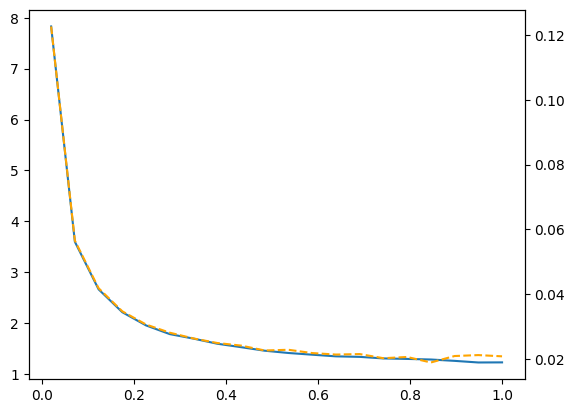

In [14]:
plt.plot(tau_ds/T, ks)
plt.twinx()
plt.plot(tau_ds/T, d_thetas, c='orange', linestyle='dashed')

In [15]:
tau_d = T / 3
delay_i = round(tau_d / dt)

In [16]:
alpha, tau_d / T, simulation_duration/T, beta

(125.0, 0.33333333333333337, 20.500000000000004, 0)

In [17]:
x = get_x_from_u(u(t[-1] + theta, T))
w_ = get_w_from_x(x, delay_i)

In [18]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True, init_travel=1)

CPU times: user 2.74 s, sys: 4.89 ms, total: 2.75 s
Wall time: 2.75 s


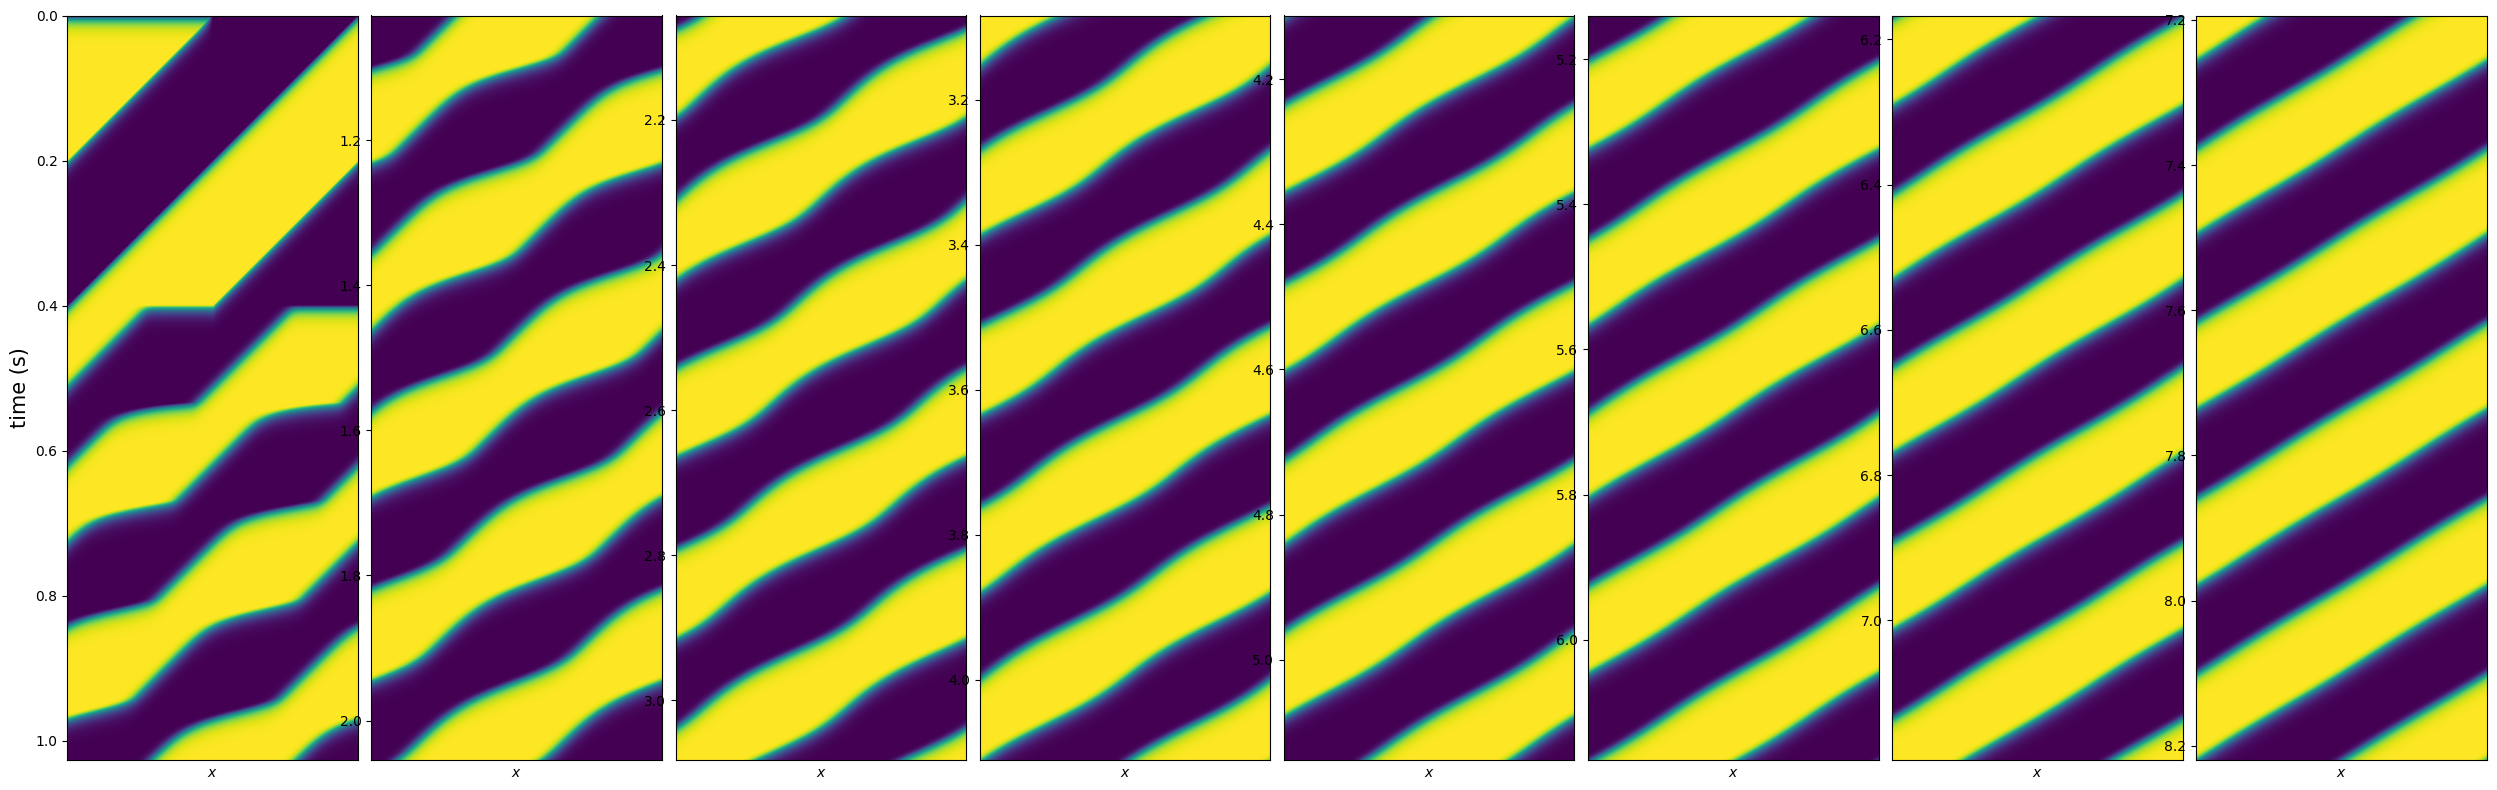

In [19]:
plot_activity(X, t, bins=8, cutoff_div=None)

### how does $\tau_d$ influence dreaming behaviour?

In [1]:
import numpy as np

In [2]:
np.angle(np.exp(1j*(np.pi/2 + 2 * np.pi * 0.123)))

2.3436281195779856

In [6]:
np.pi/2 + 2 * np.pi * 0.123

2.3436281195779856

In [3]:
np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*0.123))

2.3436281195779856

1. how does $\tau_d$ influence angle of learned weights?

$$
{w}(\Delta x, t) = \mathcal{F}^{-1}\left[\frac{2 \pi \xi {e^{i(\frac{\pi}{2} + 2\pi \xi\tau_d)}}}{\lambda T} |\mathcal{F}_x[{r}(x, t)]|^2\right](\Delta x, t)
$$

$$
\theta_{\Delta x}[w(\Delta x, t)](t) = \text{arg}\Big(\mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$
$$
= \text{arg}\Big(\frac{2 \pi {e^{i\big(\frac{\pi}{2} + \frac{2\pi\tau_d}{T}\big)}}}{\lambda T^2} |\mathcal{F}_x[{r}(x, t)]|^2\Big)
$$
$$
= \text{arg}\Big({e^{i\big(\frac{\pi}{2} + \frac{2\pi\tau_d}{T}\big)}}\Big) + \text{arg}\Big(\mathcal{F}_x[{r}(x, t)] \overline{\mathcal{F}_x[r(x, t)]}\Big)
$$
$$
= \frac{\pi}{2} + \frac{2\pi\tau_d}{T} + \text{arg}\Big(\mathcal{F}_x[{r}(x, t)]\Big) -\text{arg}\Big({\mathcal{F}_x[r(x, t)]}\Big) + 2\pi n
$$
$$
= \frac{\pi}{2} + \frac{2\pi\tau_d}{T} + 2\pi n
$$

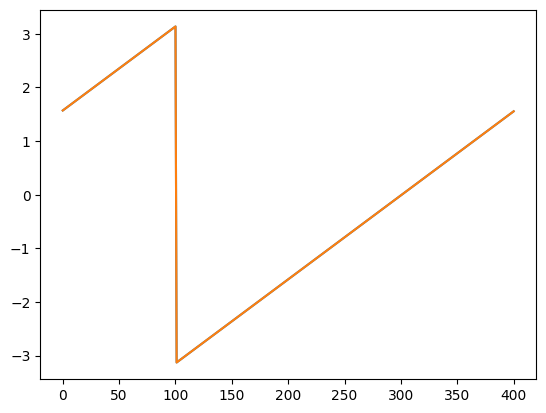

In [20]:
plt.plot([get_angle(get_w_from_x(X[N//2], d)) for d in range(N)])
#plt.plot([to_theta(np.angle(1j)-np.angle(np.exp(-2*np.pi*1j*freqs[1]*(d-0.5)))) for d in range(N)])
plt.plot([to_theta(np.angle(1j)-np.angle(np.exp(-2*np.pi*1j*tau/T))) for tau in np.linspace(0, T, N, endpoint=False)])

2. fixed points and limit cycles in dependance of weight angle

$$
    \theta_x[\varphi\big([w(x', t) * r(x', t - \tau_d)](x, t)\big)](t)
$$

$$
    = \text{arg}\Bigg(\mathcal{F}_x\Big[\varphi\big([w(x', t) * r(x', t - \tau_d)](x, t)\big)\Big]\Big(\xi=\frac{1}{T}, t\Big)\Bigg)
$$

$$
    = \text{arg}\Big(\mathcal{F}_x[w(x', t)*{r}(x', t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
    =\text{arg}\Big(\mathcal{F}_{\Delta x}[w(\Delta x, t)]\Big(\xi=\frac{1}{T}, t\Big)\mathcal{F}_x[{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
    = \theta_{\Delta x}[w](t) + \theta_x[r](t-\tau_d)
$$

stable frequencies: $\omega_x[r](t) = \frac{\partial}{\partial t}\frac{\theta_x[r](t)}{2 \pi}$

$$
\tau_r \frac{\partial}{\partial t} r(x, t) = -r(x, t) + \varphi\big([w(x', t) * r(x', t - \tau_d)](x, t)\big)
$$

$$
\mathcal{F}_x\Big[\tau_r \frac{\partial}{\partial t} r(x, t)\Big]\Big(\xi=\frac{1}{T}, t\Big) + \mathcal{F}_x\Big[r(x, t)\Big]\Big(\xi=\frac{1}{T}, t\Big) = \mathcal{F}_x\Big[\varphi\big([w(x', t) * r(x', t - \tau_d)](x, t)\big)\Big]\Big(\xi=\frac{1}{T}, t\Big)
$$

$$
\Big(1 + 2 \pi i \frac{\tau_r\omega_x[r](t)}{T}\Big)\mathcal{F}_x\Big[r(x, t)\Big]\Big(\xi=\frac{1}{T}, t\Big) = \mathcal{F}_x\Big[\varphi\big([w(x', t) * r(x', t - \tau_d)](x, t)\big)\Big]\Big(\xi=\frac{1}{T}, t\Big)
$$

$$
\text{arg}\Bigg(\Big(1 + 2 \pi i \frac{\tau_r\omega_x[r](t)}{T}\Big)\mathcal{F}_x\Big[r(x, t)\Big]\Big(\xi=\frac{1}{T}, t\Big)\Bigg) = \text{arg}\Bigg(\mathcal{F}_x\Big[\varphi\big([w(x', t) * r(x', t - \tau_d)](x, t)\big)\Big]\Big(\xi=\frac{1}{T}, t\Big)\Bigg)
$$

$$
\text{arg}\Bigg(1 + 2 \pi i \frac{\tau_r\omega_x[r](t)}{T}\Bigg) + \theta_x[r](t) = \theta_x[w](t) + \theta_x[r](t-\tau_d) + 2\pi n
$$

$$
\text{arctan}\Bigg(2 \pi \frac{\tau_r\omega_x[r](t)}{T}\Bigg) = \theta_x[w](t) + \theta_x[r](t-\tau_d) - \theta_x[r](t) + 2\pi n
$$

$$
\text{arctan}\Bigg(2 \pi \frac{\tau_r\omega_x[r](t)}{T}\Bigg) = \theta_x[w](t) - 2 \pi \frac{\tau_d}{T} \omega_x[r](t) + 2\pi n
$$

### linear approximation

$$
2 \pi \frac{\tau_r\omega_x[r](t)}{T} = \theta_x[w](t) - 2 \pi \frac{\tau_d}{T} \omega_x[r](t) + 2\pi n
$$

$$
0 = \theta_x[w](t) - (\tau_d + \tau_r) \frac{2 \pi}{T} \omega_x[r](t) + 2\pi n
$$

$$
\omega_x[r](t) = \frac{T(2\pi n + \theta_x[w](t))}{2 \pi (\tau_d + \tau_r)}
$$

### cubic approximation

taylor approximation of arctan

approximation inaccurate for slow firing rate time constant with short period (low $T$, high $\tau_r$, high $\omega$)
good approximation till $|\omega| < 5$ for $\tau_r / T \approx 0.02$

$$
2 \pi \frac{\tau_r\omega_x[r](t)}{T} - \frac{(2 \pi \tau_r)^3}{3T^3} \omega_x[r](t)^3 = \theta_x[w](t) - 2 \pi \frac{\tau_d}{T} \omega_x[r](t) + 2\pi n
$$

$$
0 = \frac{(2 \pi \tau_r)^3}{3T^3} \omega_x[r](t)^3 - (\tau_d + \tau_r)\frac{2 \pi}{T}\omega_x[r](t) + \theta_x[w](t) + 2\pi n
$$

depressed cubic

$$
0 = \omega_x[r](t)^3 - \frac{(\tau_d + \tau_r)6 \pi T^2}{(2 \pi \tau_r)^3}\omega_x[r](t) + \frac{3T^3}{(2 \pi \tau_r)^3}(\theta_x[w](t) + 2\pi n)
$$

Trigonometric solution for three real roots
$$
 {\omega_x[r](t)=2\,{\sqrt {-{\frac {p}{3}}}}\,\cos \left[\,{\frac {1}{3}}\arccos \left({\frac {3q}{2p}}{\sqrt {\frac {-3}{p}}}\,\right)-{\frac {2\pi j}{3}}\,\right]\quad {\text{with }}j \in \{0,1,2\}.}
$$
for
$$
p = - \frac{(\tau_d + \tau_r)6 \pi T^2}{(2 \pi \tau_r)^3} \text{,\hspace{1em}} q = \frac{3T^3}{(2 \pi \tau_r)^3}(\theta_x[w](t) + 2\pi n)
$$
But we are only interested in the middle one ($j=1$)

discriminant (necessary??)

$\tau_d > \tau_r$
$$
D = \frac{1}{27}\Bigg(-\frac{(\tau_d + \tau_r)6 \pi T^2}{(2 \pi \tau_r)^3}\Bigg)^3 + \frac{1}{4}\Bigg(\frac{3T^3}{(2 \pi \tau_r)^3}\Big(\theta_x[w](t)\Big)\Bigg)^2
$$

# simulation

In [44]:
n = 4
q = (3 * T**3 / (2 * np.pi * tau_x)**3 * (np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*tau_d / T)))) + 2 * np.pi * n
p = (-(tau_d + tau_x) * 6 * np.pi * T**2 / (2 * np.pi * tau_x)**3)

In [45]:
j = 1
2 * np.sqrt(-p/3) * np.cos(1/3 * np.arccos(3*q / (2*p) * np.sqrt(-3/p)) - 2*np.pi*j/3)

3.521814078817237

In [28]:
omegas = np.linspace(-6, 6, 250)
lhs = np.array([np.angle(1 + 2 * np.pi * 1j * tau_x * omega / T) for omega in omegas])
rhs = np.array([to_theta(np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*tau_d/T)) + to_theta(-omega * 2 * np.pi * delay_i / N)) for omega in omegas])
slope = 2 * np.pi * tau_x / T
approx_lhs = [slope * omega - (slope**3)/3 * omega**3 for omega in omegas]
k = infer_frequencies(X[:, 0])[4000:4500].mean()
thresh = 0.06
omega_roots_numeric = omegas[np.abs(rhs-lhs) < thresh]

In [29]:
omega_roots_numeric

array([-4.02409639, -1.18072289,  1.6626506 ,  4.5060241 ])

In [30]:
k

1.6491675984728542

In [85]:
coeff_set = [
    [
        np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*tau_d / T)) + k_ * 2 * np.pi,
        -(tau_d + tau_x) * 2 * np.pi / T,
        0,
        to_theta((2 * np.pi * tau_x)**3/(3*T**3))
    ]
    for k_ in range(-3, 3)
]
omega_roots = [np.roots(coeffs[::-1])[2] for coeffs in coeff_set]
omega_roots

[-6.939425941582495,
 -4.029348916527546,
 -1.1798975954236157,
 1.652511175436145,
 4.5088764227200295,
 7.433858131064422]

In [31]:
tau_d, tau_x

(0.13366666666666668, 0.008)

Text(0.5, 1.0, 'cubic polynomial with roots as stable frequencies')

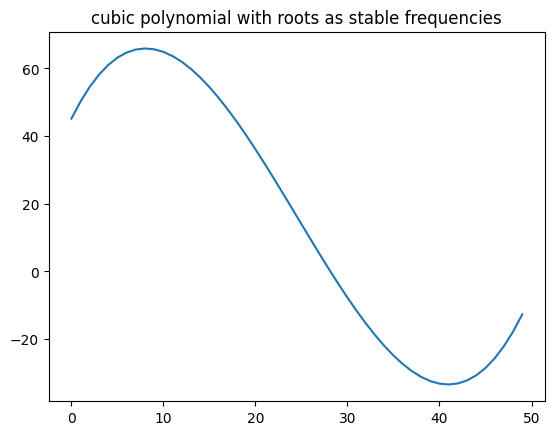

In [102]:
plt.plot(np.polynomial.polynomial.Polynomial(coeffs)(np.linspace(-50, 50)))
plt.title('cubic polynomial with roots as stable frequencies')

(-10.0, 10.0)

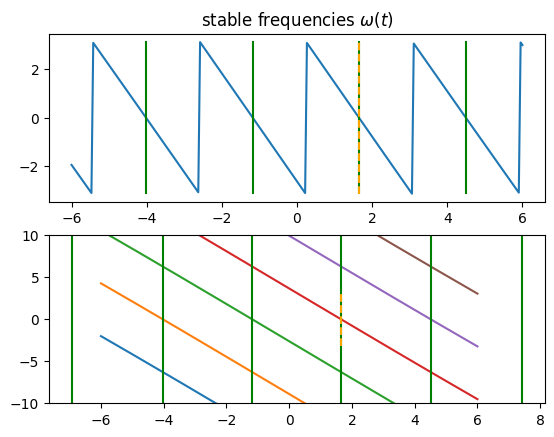

In [100]:
plt.subplot(211)
plt.plot(omegas, to_theta(rhs-lhs))
plt.vlines(omega_roots_numeric, -np.pi, np.pi, color='green')
plt.vlines(k, -np.pi, np.pi, color='orange', linestyle='dashed')
plt.title(r'stable frequencies $\omega_x[r](t)$')
plt.subplot(212)
for coeffs in coeff_set:
    plt.plot(omegas, np.polynomial.polynomial.Polynomial(coeffs)(omegas))
plt.vlines(omega_roots, -10, 10, color='green')
plt.vlines(k, -np.pi, np.pi, color='orange', linestyle='dashed')
plt.ylim(-10, 10)

Text(0.5, 1.0, 'accuracy of taylor series approximation of arctan')

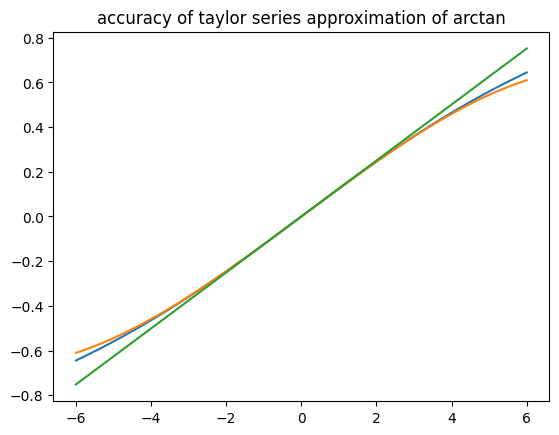

In [98]:
plt.plot(omegas, lhs)
plt.plot(omegas, [slope * omega - (slope**3)/3 * omega**3 for omega in omegas])
#lhs_f = np.polynomial.polynomial.Polynomial([0, a, 0, -(a**3)/3])
#plt.plot(omegas, lhs_f(omegas), linestyle='dashed')
plt.plot(omegas, [slope * omega for omega in omegas])
plt.title('accuracy of taylor series approximation of arctan')

In [95]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True, init_travel=omega_roots[3])

CPU times: user 2.87 s, sys: 5.83 ms, total: 2.87 s
Wall time: 2.87 s


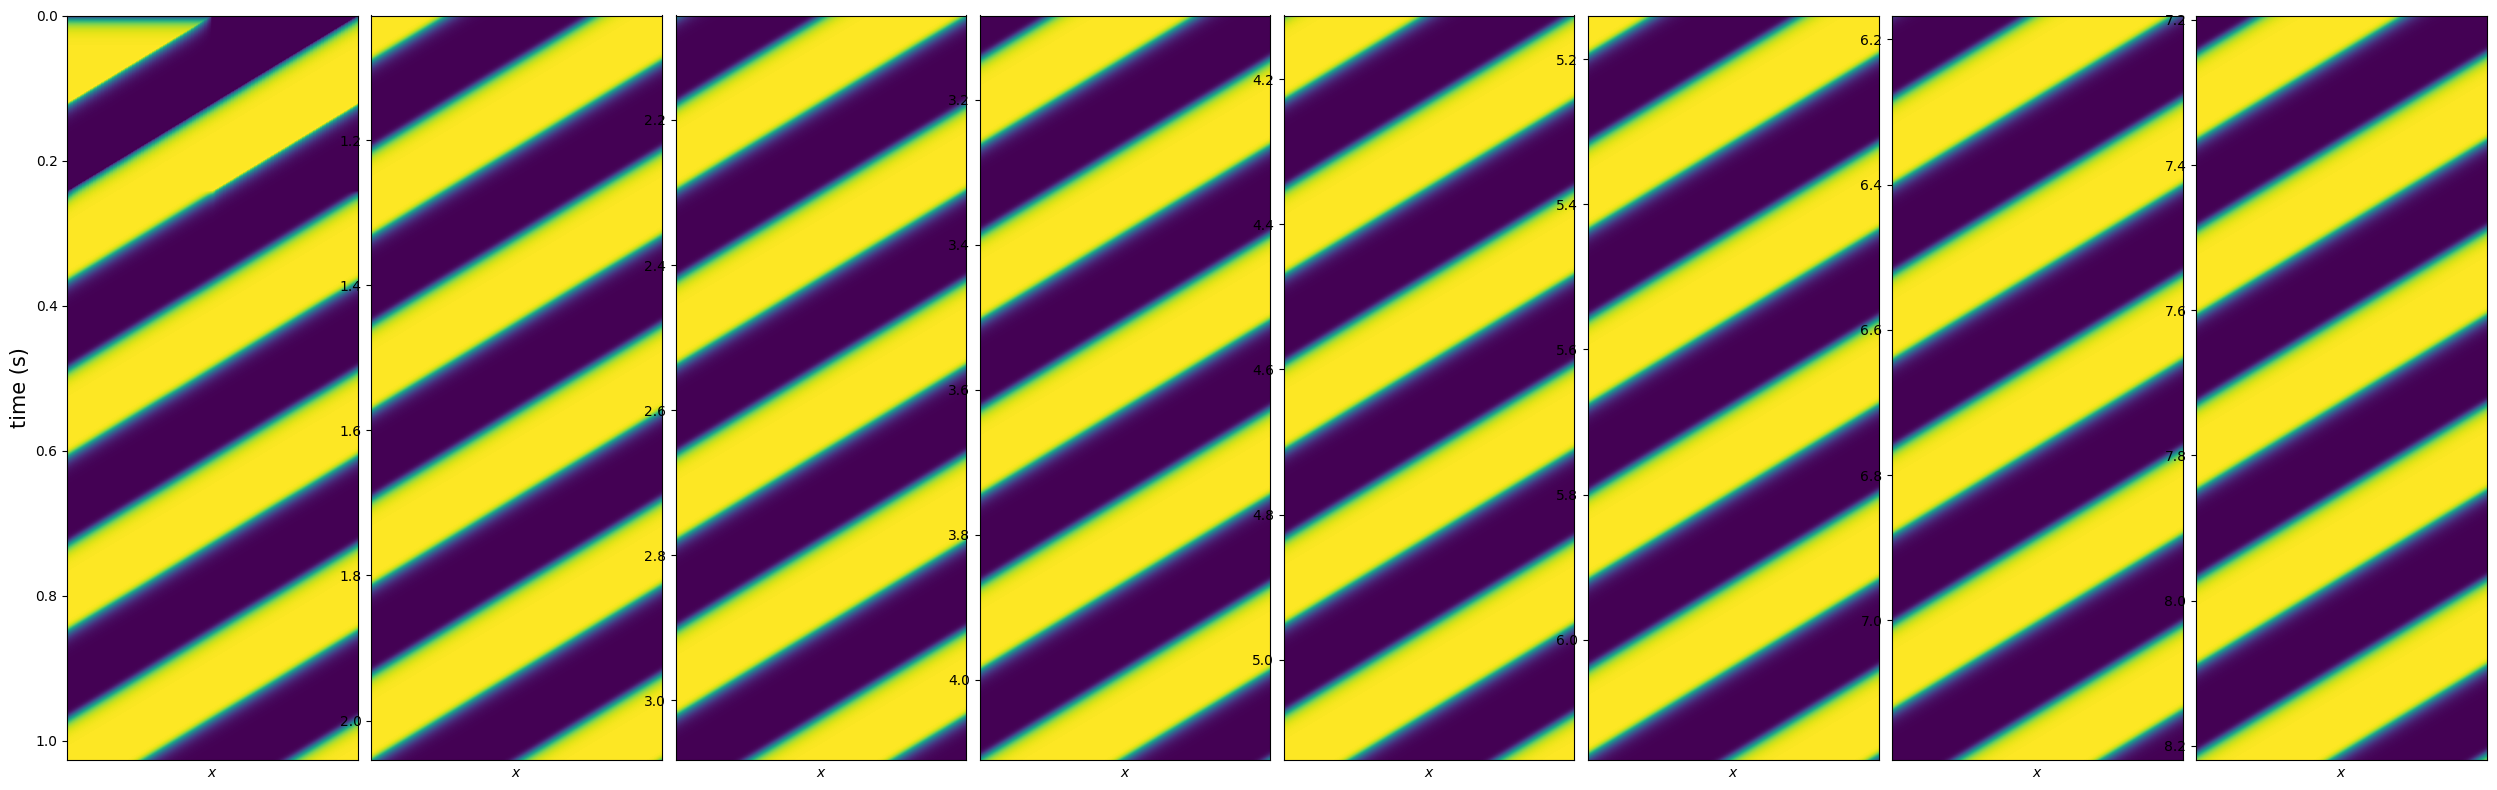

In [96]:
plot_activity(X, t, bins=8, cutoff_div=None)

In [97]:
k = infer_frequencies(X[:, 0])[3000:4000].mean()
k, omega_roots[3]

(1.6611283152226277, 1.652511175436145)

## special case $\tau_d/T = 0.75$, no offset and therefore stable at $\omega = 0$

In [103]:
np.angle(1j), np.angle(np.exp(-2*np.pi*1j*0.75))

(1.5707963267948966, 1.5707963267948968)

In [139]:
tau_d = T * 0.75
delay_i = round(tau_d / dt)

In [140]:
alpha, tau_d / T, simulation_duration/T, beta

(125.0, 0.75, 20.500000000000004, 0)

In [141]:
x = get_x_from_u(u(t[-1] + theta, T))
w_ = get_w_from_x(x, delay_i)

In [142]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True, init_travel=0)

CPU times: user 2.83 s, sys: 11.9 ms, total: 2.84 s
Wall time: 2.84 s


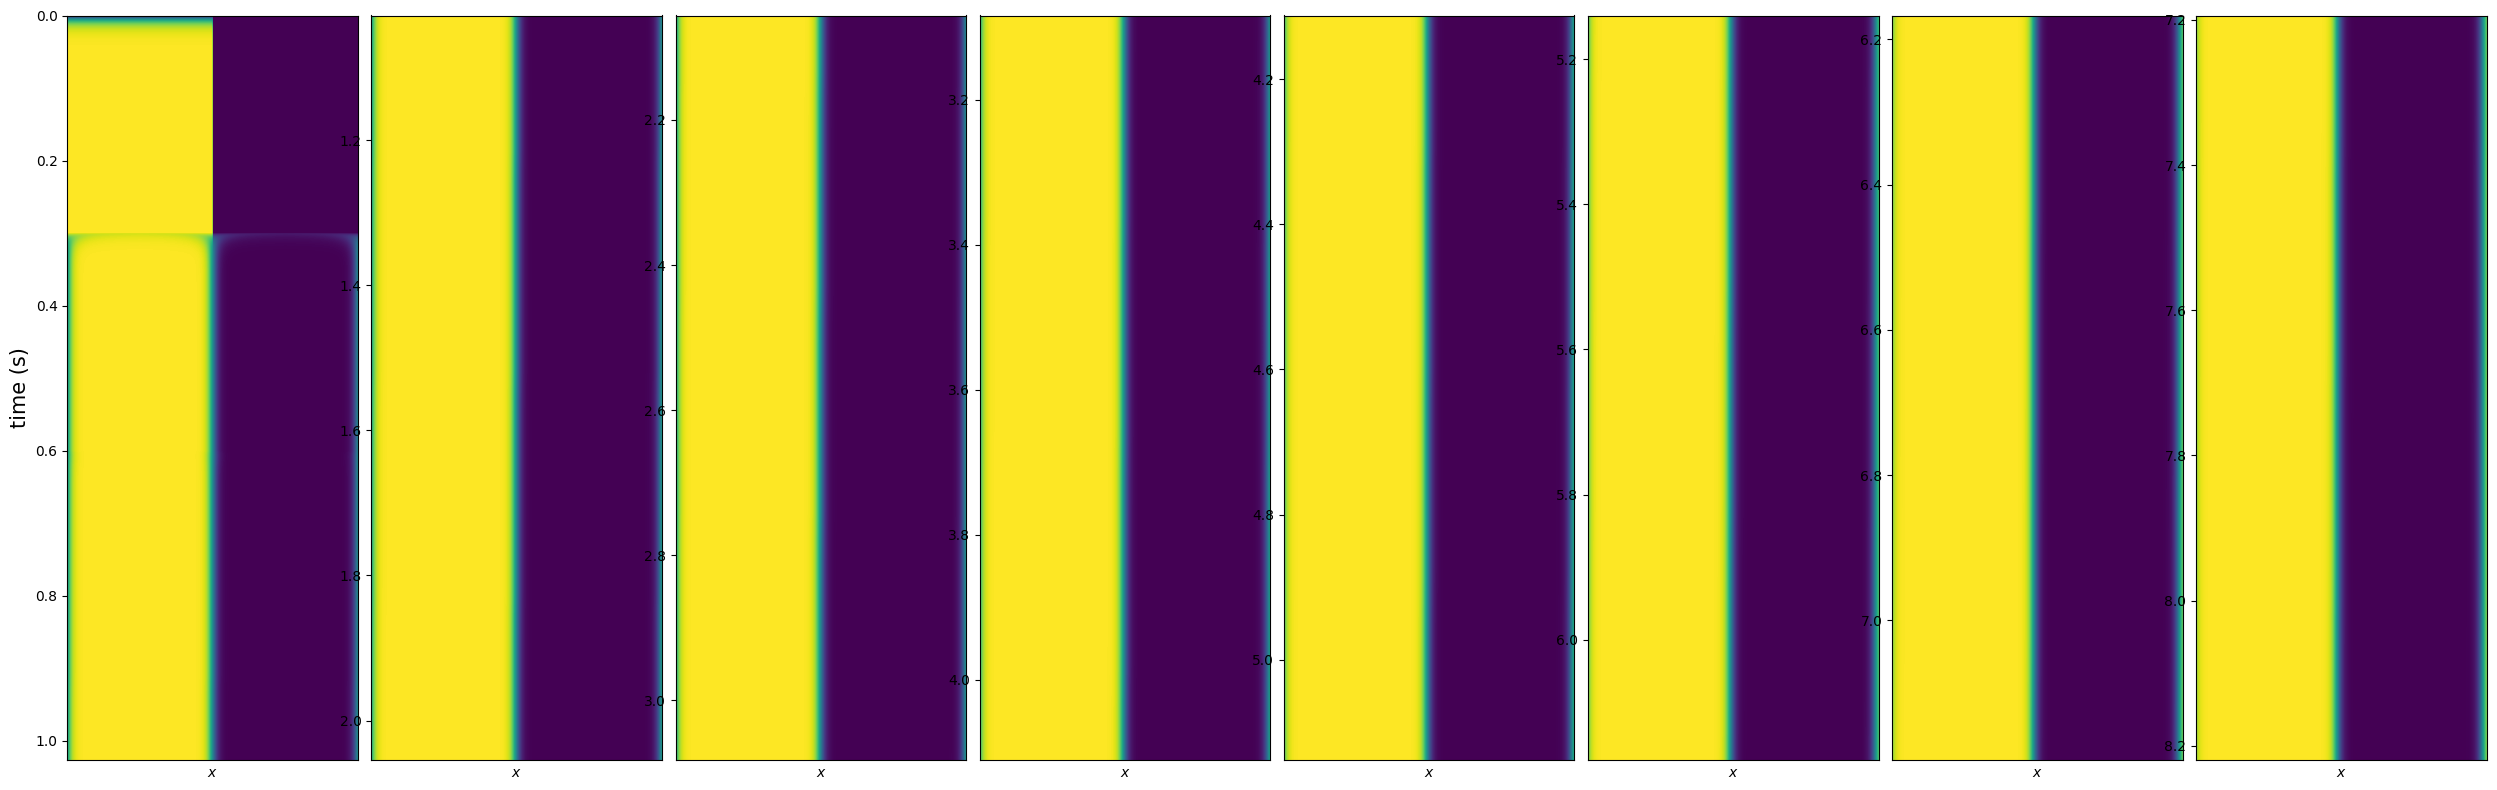

In [143]:
plot_activity(X, t, bins=8, cutoff_div=None)

### verification and other stuff

In [18]:
k = infer_frequencies(X[:, 0])[3000:4000].mean()
to_theta(get_angles(X[:-delay_i]) - get_angles(X[delay_i:]))[-1], to_theta(-k * 2 * np.pi * delay_i / N)

(2.861447124934598, 2.8621086799676734)

In [19]:
get_angle(w_), to_theta(np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*tau_d/T)))

(-2.6087674678487933, -2.617993877991495)

In [20]:
i = 3100
np.angle(1 + 2 * np.pi * 1j * tau_x * k / T) + get_angle(X[i]), to_theta(get_angle(w_) + get_angle(X[i-delay_i+1]))

(2.880081840279612, 2.883733019537834)

In [163]:
def extract_fundamental(f):
    fundamental = np.zeros_like(f, dtype=complex)
    fundamental[1] = np.fft.fft(f)[1]
    return np.fft.ifft(fundamental)

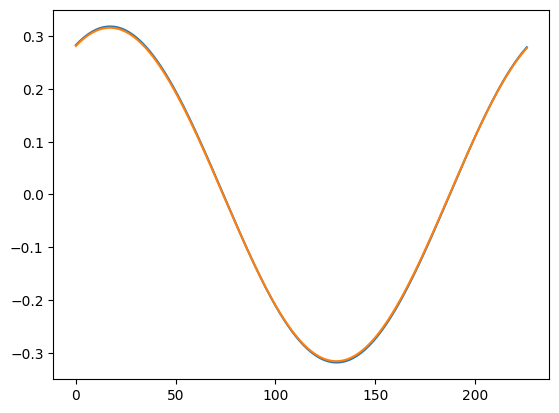

In [166]:
i = -200
plt.plot(np.fft.ifft((1 + 2 * np.pi * 1j * tau_x * k / T) * np.fft.fft(extract_fundamental(X[i]))).real)
plt.plot(extract_fundamental(phi(f_I_conv_circ_fft(w_, X[i-delay_i+1]))).real)

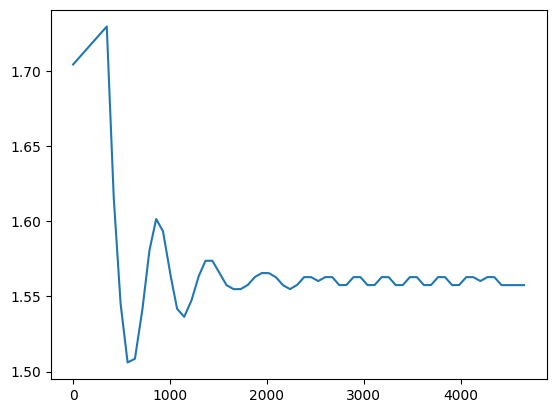

In [18]:
plt.plot(infer_frequencies(X[:, 0]))

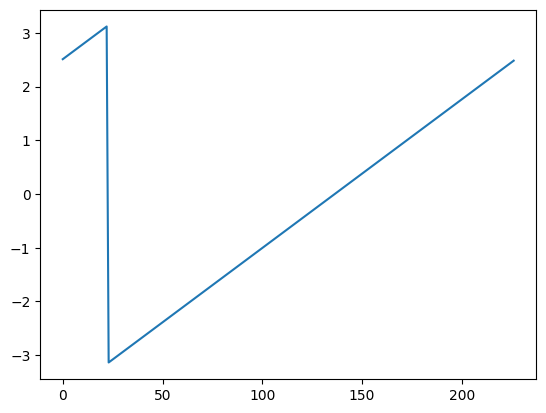

In [101]:
plt.plot(
    get_angles(np.array([f_I_conv_circ_fft(get_w_from_x(X[1], d), X[100]) for d in range(N)]))
)

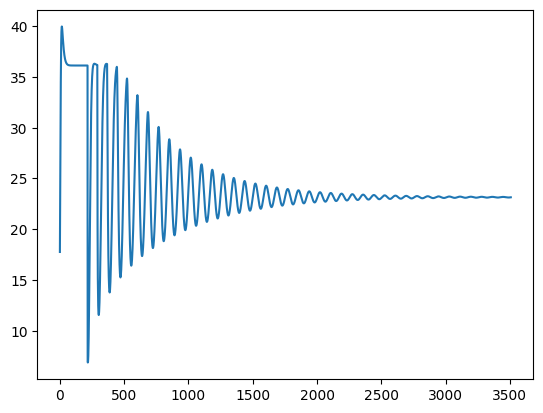

In [75]:
plt.plot(get_amps(X[10:-1]) / get_amps(DX[10:]))
#plt.plot(get_amps(DX[1:]))

In [67]:
d_theta = to_theta(get_angles(X[1:]) - get_angles(X[:-1]))
d_theta2 = to_theta(
    get_angles(X[:-1]+DX)
    -get_angles(X[:-1])
)

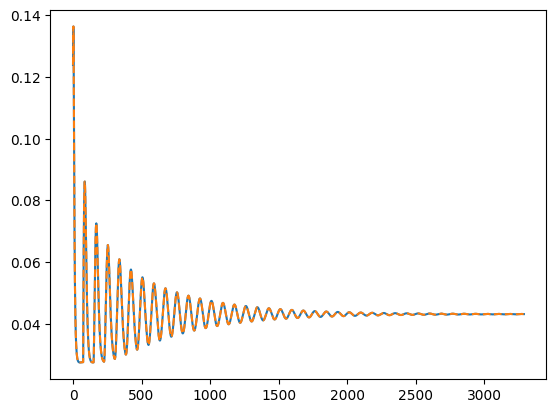

In [69]:
plt.plot(d_theta[N:])
plt.plot(d_theta2[N:], linestyle='dashed')

In [66]:
np.angle(tau_x/dt*np.exp(1j*get_angles(X[1:])) + np.exp(1j*get_angles(DX)))

array([-1.5431171 , -1.52707762, -1.51028836, ...,  2.68794692,
        2.73115419,  2.77435781])

In [22]:
np.angle(tau_x/dt*np.exp(1j*get_angles(X[1:])) + np.exp(1j*get_angles(DX)))

array([-1.5431171 , -1.52707762, -1.51028836, ...,  2.68794692,
        2.73115419,  2.77435781])

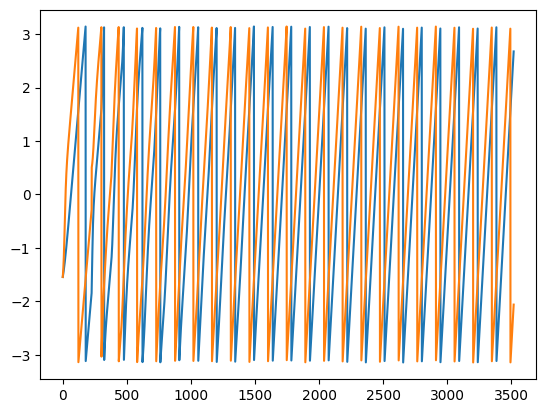

In [36]:
plt.plot(get_angles(X[1:]))
plt.plot(get_angles(DX))

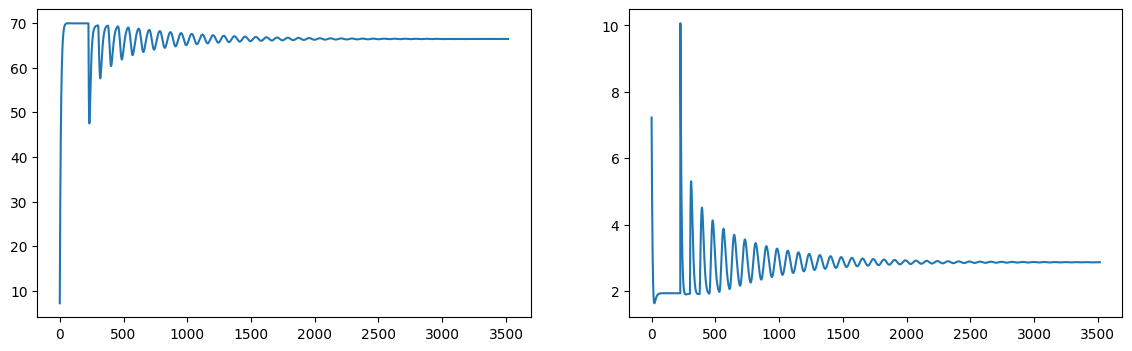

In [62]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(get_amps(X[1:]))
plt.subplot(122)
plt.plot(get_amps(DX))

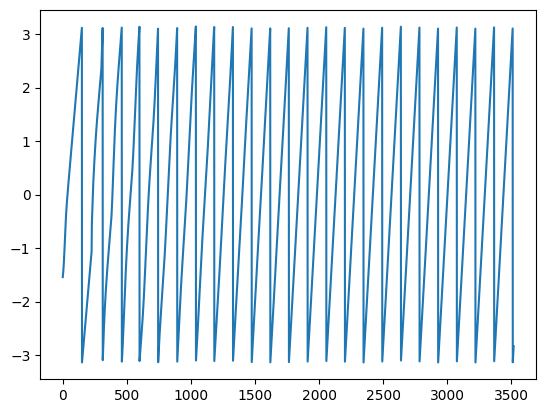

In [34]:
plt.plot(np.angle(np.exp(1j*get_angles(X[1:])) + np.exp(1j*get_angles(DX))))

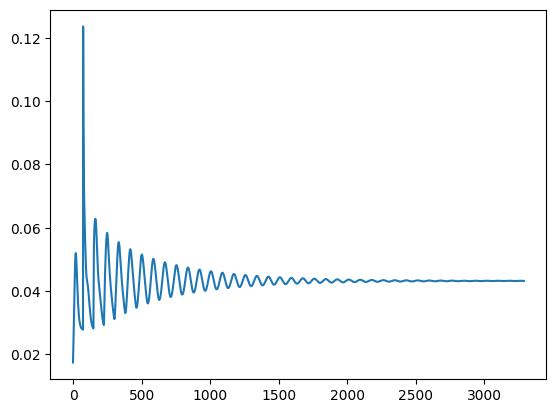

In [41]:
plt.plot(to_theta(np.angle(np.exp(1j*get_angles(DX)))[1:] - np.angle(np.exp(1j*get_angles(DX)))[:-1])[N:])

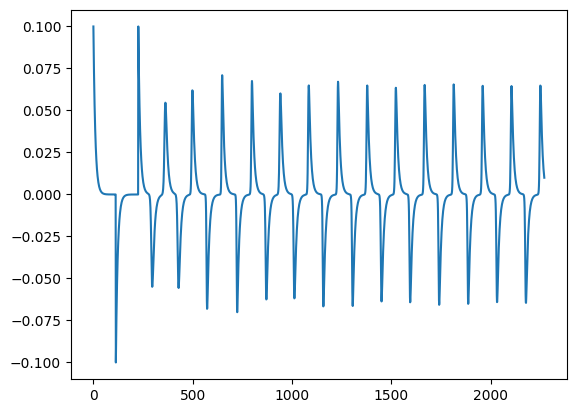

In [55]:
plt.plot(DX[:10*N, 0])

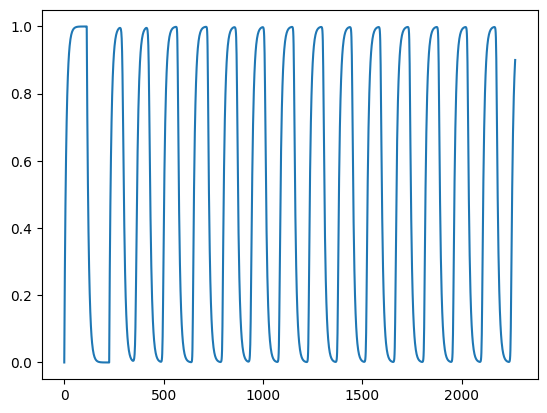

In [56]:
plt.plot(X[:10*N, 0])

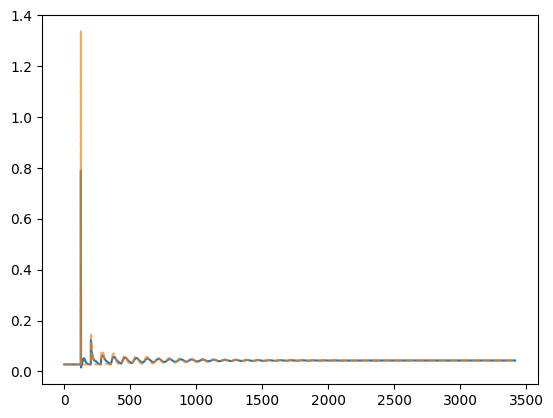

In [51]:
#plt.plot(to_theta(np.angle(np.fft.fft(X[1:], axis=1)[:, 1]) - np.angle(np.fft.fft(X[:-1], axis=1)[:, 1]))[100:])
plt.plot(to_theta(np.angle(np.fft.fft(DX[1:], axis=1)[:, 1]) - np.angle(np.fft.fft(DX[:-1], axis=1)[:, 1]))[99:])
plt.plot(to_theta(np.angle(np.fft.fft((DX + dt*alpha*X[:-1])[1:], axis=1)[:, 1]) - np.angle(np.fft.fft((DX + dt*alpha*X[:-1])[:-1], axis=1)[:, 1]))[99:],
         linestyle='dashed', alpha=0.7)

In [12]:
DX.shape, X.shape

((3518, 227), (3519, 227))

In [13]:
get_angle(w_) + get_angle(X[N-delay_i])

-4.193403065963254

In [14]:
get_angle(X[N-delay_i])

-1.5707963267948966

In [15]:
get_angle(X[N-10])

-1.5707963267948966

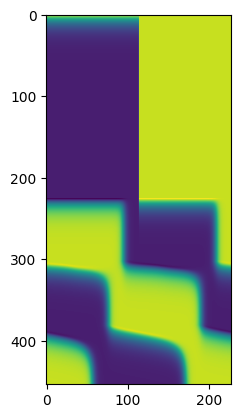

In [22]:
plt.imshow(DX[:2*N] - X[:2*N])

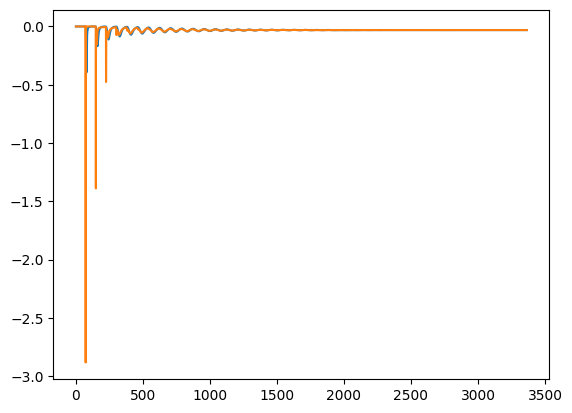

In [17]:
plt.plot(to_theta(get_angles(X)[2*delay_i+2:] - get_angles(X)[2*delay_i+1:-1]))
plt.plot(to_theta(get_angles(DX)[2*delay_i+1:] - get_angles(DX)[2*delay_i:-1]))

In [18]:
I = np.array([
        f_I_conv_circ_fft(w_, x)
        for x in X[1:N]
    ])

In [21]:
get_angle(X[N//2]), -np.pi/2

(-1.5707963267948966, -1.5707963267948966)

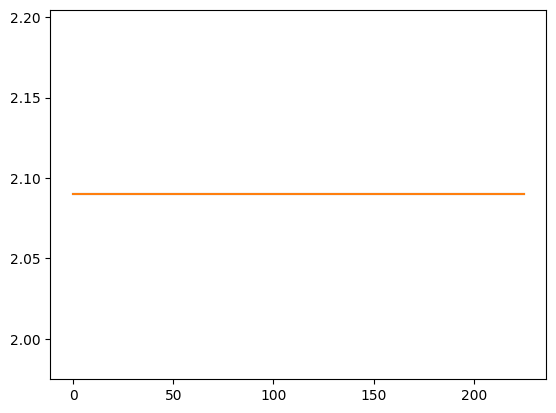

In [19]:
plt.plot(get_angles(I))
plt.plot(to_theta(get_angle(w_) + get_angles(X[1:N])))

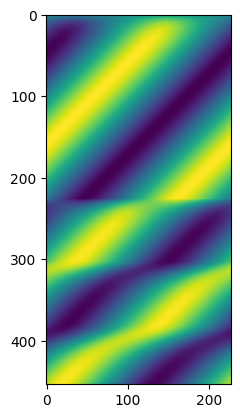

In [45]:
plt.imshow(
    np.array([
        f_I_conv_circ_fft(w_, x)
        for x in X[:2*N]
    ])
)